<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Light_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Jack3690/INSIST --quiet
!pip install git+https://github.com/Srivardini/tara --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.9/195.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 33.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.8 MB/s eta 0:00:00


In [2]:
import pista as pt
from pista.utils import Xmatch, generate_psf
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from astropy.table import Table, vstack
from astropy.modeling.fitting import LevMarLSQFitter
from PIL import Image, ImageDraw
import cv2
import imageio
from glob import glob
from scipy.stats import skewnorm
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.io import fits

In [3]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
data_path = pt.data_dir

In [5]:
def light_curve(x, y, cadence):
  x_new = np.arange(x[0], x[-1], cadence)
  y_new = np.interp(x_new, x, y)
  return x_new, y_new

In [25]:
start = 0
end = 12*60

num_points = 1000

x_in = np.arange(start, end, 1)
y_in = skewnorm.pdf(x_in, 10, loc=100, scale=3*60)

t,dmag = light_curve(x_in, y_in, 0.1)
dmag = -dmag/dmag.max()

In [26]:
x_in = np.arange(0, len(y_in), 1)
t,dmag = light_curve(x_in, y_in, 0.1)
dmag /= dmag.max()
len(dmag)

7190

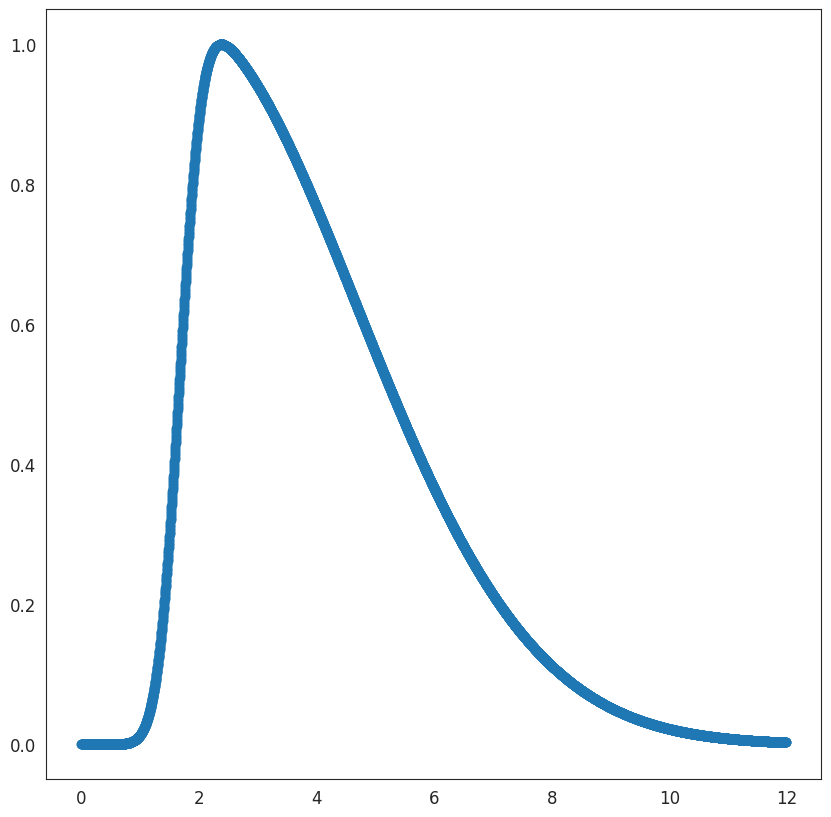

In [27]:
plt.plot(t/60,dmag,'o')

In [56]:
fwhm = 2
sigma = fwhm*gaussian_fwhm_to_sigma

In [57]:
params = {
          'sigma_x' : sigma,
          'sigma_y' : sigma,
}

In [58]:
psf = generate_psf(201, params, 'Gaussian' )

In [59]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [60]:
3.3e-6*3.3e-6/1e-4

1.089e-07

In [61]:
tel_params ={
            'aperture'       : 11*2.5,
            'pixel_scale'    : 1.25,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [],
             'coeffs'       : 2e-2,
             'theta'        : 0,
              'M_sky'      : 18,
            }

In [62]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],# [f'{data_path}/INSIST/UV/QE.dat,1,100'],
              'qe_mean'    : 0.95,
              'G1'         : 0.885009765625*68,
              'FWC'        : 58e3,
              'bit_res'    : 16,
              'bias'       : 20,
              'DFM'        : 0.01424,
              'PRNU_frac'  :  0.25/100,
              'pixel_area' : 1.089e-07,
              'DCNU'       :  0.1/100,
              'RN'         :  3.4,
              'T'          :  275,
              'DN'         :  0.01/100
              }

# **Example 1**

In [37]:
if not os.path.exists('/content/output'):
  os.mkdir('/content/output')

if not os.path.exists('/content/tar_out'):
  os.mkdir('/content/tar_out')

In [63]:
ra = np.random.uniform(10, 10+ 200/3600,15)
dec = np.random.uniform(10, 10 + 200/3600,15)
mag = np.random.uniform(10,11,15)
df = pd.DataFrame(zip(ra, dec, mag), columns = ['ra', 'dec', 'mag'])

In [ ]:
tabs = []
for i in range(len(dmag)):
  #df['ra'] = x #+ np.random.uniform(-10,10,1)[0]
  #df['dec'] = y #+ np.random.uniform(-10,10,1)[0]
  df['mag'][0] =  10 - dmag[i]

  sim = pt.Imager(df = df,tel_params = tel_params, exp_time = 0.1, plot = False,
             n_x = 300, n_y = 300)

  sim(det_params = det_params, photometry = 'Aper', detect_sources=False,
        fwhm=2)
  tabs.append(sim.phot_table[sim.phot_table['mag_in']==10 - dmag[i]])
  sim.writecomp(f'/content/output/{i}_sim.fits')
  if i >20:
    break

In [65]:
sim.zero_flux*pow(10,-11/2.5)/sim.gain

7836.3685952806645

(<Figure size 1500x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Digital \nRequested center :  RA : 10.019 degrees, Dec : 10.031 degrees'}>)

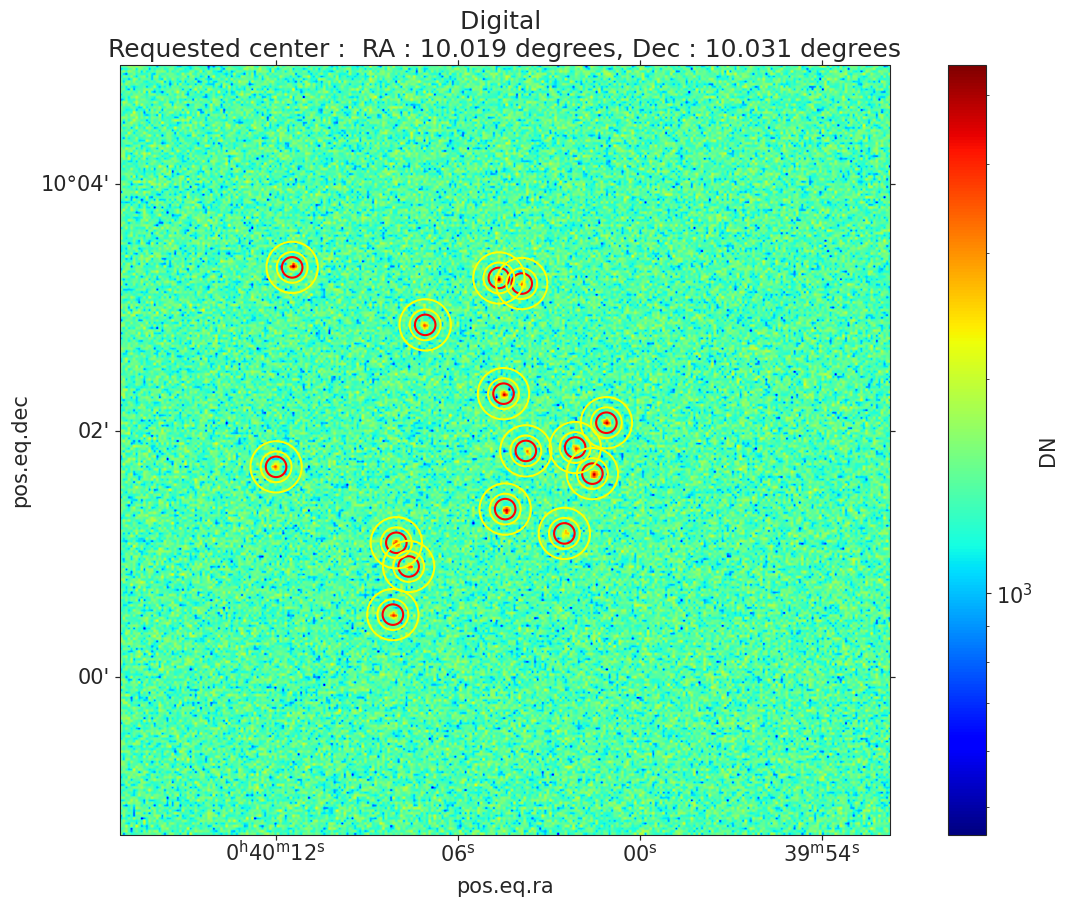

In [66]:
sim.show_image(overlay_apertures=True)

In [41]:
sim.phot_table

id,xcenter,ycenter,aperture_sum,sky_flux,flux,flux_err,SNR,ra,dec,mag_in,mag_out,mag_err
,pix,pix,,electron,electron,electron,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,141.5302003875625,190.45261596500816,93336.04827753609,1008.6360413701817,363.95290388770184,44.26042736141258,8.22298666291247,10.028700391952862,10.049670105104207,9.999999975894305,9.751401884825672,0.13158236105137625
2,78.76773114146663,75.69896746910985,81329.02110656495,1025.6376016131383,170.37741465987574,42.218615576899374,4.035599280832425,10.050829442389537,10.009824184658301,10.845180326565336,10.575484797240644,0.2681138350725485
3,218.87477736166053,172.17824274499995,81107.2289153151,1041.5303644489454,151.22300195274738,42.17996978849901,3.585185165162934,10.00142664865925,10.043323937494684,10.36663279976172,10.70497021930558,0.30179752234661134
4,168.31137601671517,149.00019996825256,83889.87269241414,1023.4200067988396,210.2545916190153,42.662291117271835,4.928347402652589,10.01925677619613,10.035276846378563,10.375175155398885,10.347151134813217,0.21954621125483853
5,149.0,58.01533280102822,82274.31091953295,1004.5704508773008,205.3458861746542,42.3829307859774,4.84501383850958,10.026066296280373,10.00368495124715,10.39562856348498,10.372799840018523,0.22332237555235637


In [42]:
sim.det_params

{'shot_noise': 'Poisson',
 'qe_response': [],
 'qe_mean': 1,
 'bias': 20,
 'G1': 60.1806640625,
 'bit_res': 16,
 'RN': 3.4,
 'PRNU_frac': 0.0025,
 'T': 275,
 'DFM': 0.01424,
 'pixel_area': 1.089e-07,
 'DCNU': 0.001,
 'DNFP': 0.0,
 'NF': 0.0,
 'FWC': 58000.0,
 'C_ray_r': 0.04,
 'DN': 0.0001}

In [67]:
tab_t = vstack(tabs)

In [45]:
tab_t.write('/content/Phot_table.fits', overwrite=True)

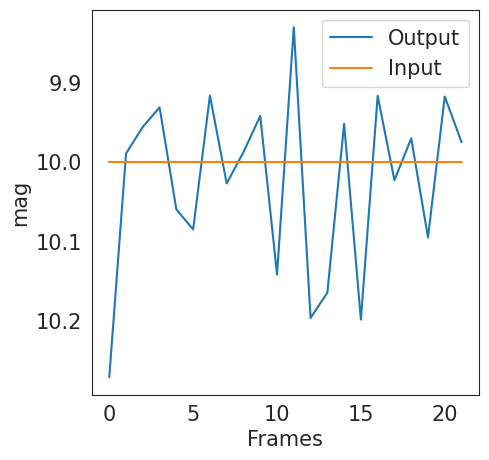

In [68]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(tab_t['mag_out'])
ax.plot(tab_t['mag_in'])
ax.set_xlabel('Frames')
ax.set_ylabel('mag')
ax.invert_yaxis()
plt.legend(['Output','Input'])

# **TARA**

In [47]:
import tara
from tara.utils import gen_plot

In [69]:
exps = glob('/content/output/*.fits')

In [70]:
exps = sorted(exps, key=lambda x: int(x.split('/')[-1].split('_')[0]))

In [71]:
tar_obj = tara.tara(exps, '/content/tar_out')

-------------------------------------------------
Input directory contains 22 '.fits' 'files
Image shape: (300, 300)
-------------------------------------------------


(<Figure size 700x700 with 1 Axes>,
 <Axes: >,
 <QTable length=10>
   id       xcenter       ...      flux_err             SNR        
              pix         ...                                      
 int64      float64       ...      float64            float64      
 ----- ------------------ ... ------------------ ------------------
     1 105.71479149842823 ...  99.90363487416043 118.08102132290533
     2 111.52984775688245 ... 101.14257647065337  262.0766712671234
     3  107.4768419623869 ... 101.05936644612174  153.9374531103125
     4 149.42391437460796 ...   100.554943364612 234.14934050643907
     5 183.07471420309804 ... 100.74447875144237 235.97583840078894
     6 188.10724670673895 ...  100.8683721844965 61.265991586861645
     7 148.74128024844842 ... 100.30866974813061 143.01713502912105
     8 117.84624960211976 ... 100.64486692903988 143.72325321627602
     9  148.2773515693792 ... 101.70135018911562  403.6322209228925
    10  67.49099079566697 ... 101.47336399217964 

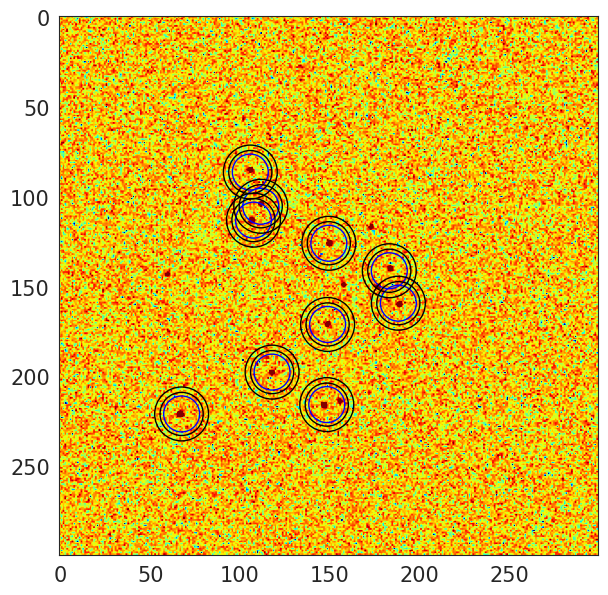

In [72]:
tar_obj.show_image(th=0.8)

In [73]:
rnge = [0,2]
step = 10

ref_pos, ref_img= tar_obj(th=0.8, rnge=rnge, step=step)

------------------------------------
Iteration: 0


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


In [74]:
phot_table = tar_obj.merge_phot_table('/content/tar_out')

100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


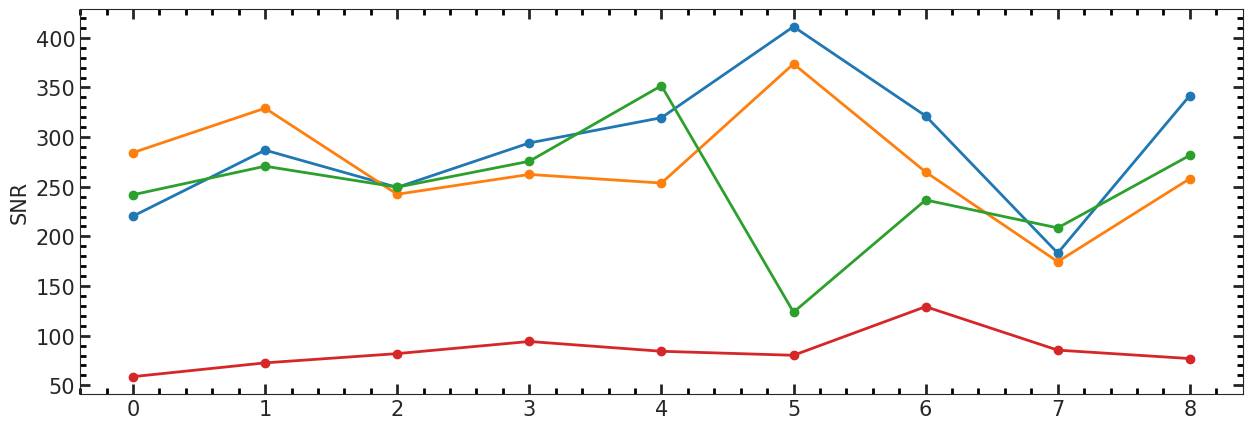

In [77]:
fig, ax = gen_plot(phot_table, 'SNR',out_dir='/content/tar_out',fmt='-o')